In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
sns.set()

import pandas as pd
import sys

In [35]:
import exman

def last(s):
    return s.values[-1]

from itertools import product

def plot_alot(x, ys, data, hue, col, row, ylims=None, ylabel=None, std=True):
    row_grid = sorted(data[row].unique()) if row else [None]
    col_grid = sorted(data[col].unique()) if col else [None]
    hue_grid = sorted(data[hue].unique())
    
    i = 0
    if ylims is None:
        ylims = data[ys].values.min(), data[ys].values.max()
    for row_i in row_grid:
        for col_i in col_grid:
            plt.subplot(len(row_grid), len(col_grid), i + 1)
            plt.ylim(*ylims)
            if i % len(col_grid) == 0:
                plt.ylabel(ylabel if ylabel else ys[0])

            i += 1
            cond = [True] * data.shape[0]
            if col:
                cond = cond & (data[col] == col_i)
            if row:
                cond = cond & (data[row] == row_i)
            tmp = data[cond]
            for (hue_i, color), (y, ls) in product(zip(hue_grid, sns.color_palette(n_colors=len(hue_grid))), zip(ys, ['-', '--'])):
                t = tmp[tmp[hue] == hue_i]
                t = t.groupby(x).agg({y: ('mean', 'std')}).reset_index()
                xpos, xlabels = np.arange(len(t[x])), t[x].values
                label = '{} ('.format(hue_i)
                for k, yv in enumerate(t[y]['mean'].values):
                    label += '{:.3f}'.format(yv)
                    label += ', ' if k != len(t[y].values) - 1 else ''
                label += ')'
                
                if std:
                    (_, caps, _) = plt.errorbar(xpos, t[y]['mean'], yerr=t[y]['std'], ecolor=color, label=label,
                                                color=color, elinewidth=2., linewidth=3., marker='o',
                                                ms=8, alpha=.8, capsize=8, linestyle=ls)
                else:
                    plt.plot(xpos, t[y]['mean'], marker='o', ms=8, lw=3, ls=ls, c=color, label=label)

            plt.legend()
            plt.xlabel(x)
#             plt.title('{} = {} | {} = {}'.format(row, row_i, col, col_i))
            plt.xticks(xpos, xlabels)



In [3]:
logs = pd.read_csv('notMNIST-MNIST-classification-logs.csv', index_col=0)

In [4]:
df = logs.groupby(['num_examples', 'lr', 'hid_dim', 'prior_list', 'init_list', 'root', 'seed', 'kl_weight']).agg({
    'ens[10]_test_acc': (last, max),
    'samp_test_acc': (last, max),
    'det_test_acc': (last, max),
    'KL': (last, min),
    'train_loss': (last, min),
    'test_nll': (last, min),
    'train_nll': (last, min),
})
df = df.reset_index()
df.columns = ['_'.join(col).strip('_') for col in df.columns.values]

bnn = df.copy()
bnn['type'] = bnn['prior_list']
bnn['test_acc_last'] = bnn['ens[10]_test_acc_last']
bnn['test_acc_max'] = bnn['ens[10]_test_acc_max']

In [44]:
logs = pd.read_csv('notMNIST-MNIST-classification-logs-vanilla-l2.csv', index_col=0)

In [45]:
df = logs.groupby(['num_examples', 'lr', 'hid_dim', 'l2', 'init_list', 'root']).agg({
    'test_acc': (last, max),
    'test_nll': (last, min)
})
df = df.reset_index()
df.columns = ['_'.join(col).strip('_') for col in df.columns.values]

# det = df[df['init_list'] == "['vae', 'xavier']"]
df['type'] = "['det']" 
det = df[(df['init_list'] == "['vae', 'vae']") & (df['lr'] <= 1e-3)]

In [46]:
det['num_examples'].unique()

array([  10,   50,  100,  200,  500, 1000])

/Vol0/user/hse/toretto.gtr/miniconda3/lib/python3.6/site-packages/pandas/core/frame.py:6211: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.

  sort=sort)


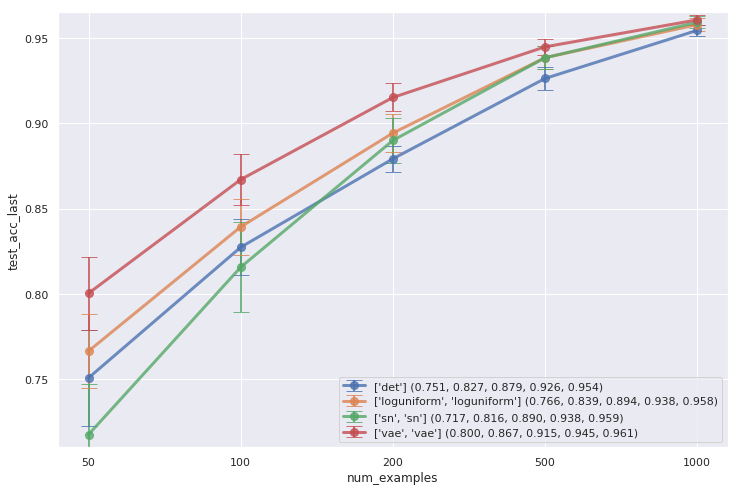

In [47]:
x='num_examples'
ys=['test_acc_last']
data=bnn.append(det).query('num_examples > 10')
hue='type'
col=''
row=''
plt.figure(figsize=(12, 8))

plot_alot(x, ys, data, hue, col, row, ylims=(0.71, .965))